<a href="https://colab.research.google.com/github/IVMRanepa/Blockchain-technology/blob/main/The_impact_of_the_Bank_of_Russia's_key_rate_on_monetary_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Высокая ключевая ставка Банка России в 2025 году и её влияние на денежно‑кредитную политику

Демонстрационный блокнот для анализа ключевой ставки, инфляции и построения простых моделей на Python 3 (ориентирован на запуск в Google Colaboratory).

In [ ]:
# Если вы запускаете этот блокнот в Google Colab, раскомментируйте при необходимости:
!pip install statsmodels matplotlib pandas scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8')

## 1. Загрузка и анализ данных по ключевой ставке

В этом разделе мы загружаем исторические данные по ключевой ставке Банка России.

Предполагается, что вы заранее скачали CSV-файл с Kaggle:

- Kaggle dataset: **Key rate Central Bank of Russia (Ключевая ставка)**.
- Ссылка: https://www.kaggle.com/datasets/alexanderkobzar/key-rate-central-bank-of-russia

Файл, например, может называться `key_rate.csv` и содержать столбцы `date` и `value`.

In [ ]:
# @title Загрузка данных по ключевой ставке (локальный CSV)
# Загрузите файл `key_rate.csv` в окружение Colab (через меню Files),
# затем выполните этот код.

key_rate = pd.read_csv("key_rate.csv", parse_dates=["date"])
key_rate = key_rate.rename(columns={"value": "key_rate"})

# Фильтрация периода 2019–2025 гг.
mask = (key_rate["date"] >= "2019-01-01") & (key_rate["date"] <= "2025-12-31")
key_rate_2019_2025 = key_rate.loc[mask].copy()

key_rate_2019_2025.head()

,date,rate,is_changed
1933,2019-01-01,7.75,0
1934,2019-01-02,7.75,0
1935,2019-01-03,7.75,0
1936,2019-01-04,7.75,0
1937,2019-01-05,7.75,0


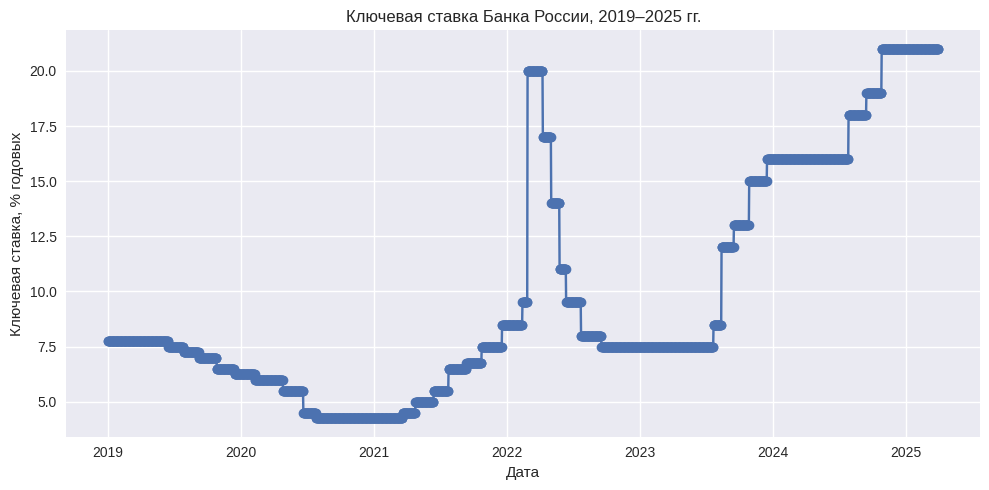

,rate
count,2283.000000
mean,9.836180
std,5.229347
min,4.250000
25%,6.250000
50%,7.500000
75%,15.000000
max,21.000000


In [ ]:
# Визуализация динамики ключевой ставки 2019–2025 гг.
plt.figure(figsize=(10, 5))
plt.plot(key_rate_2019_2025["date"], key_rate_2019_2025["rate"], marker="o", linestyle="-")
plt.title("Ключевая ставка Банка России, 2019–2025 гг.")
plt.xlabel("Дата")
plt.ylabel("Ключевая ставка, % годовых")
plt.grid(True)
plt.tight_layout()
plt.show()

key_rate_2019_2025["rate"].describe()

## 2. Инфляция и совместный анализ со ставкой

Для анализа связи ключевой ставки и инфляции используем внешний датасет с инфляцией в России.

Вариант:
- Kaggle dataset: **Inflation in Russia – Surveys VS Central Bank**.
- Ссылка: https://www.kaggle.com/datasets/zaborshicov/inflation-in-russia-surveys-vs-central-bank

Предполагаемый формат файла `inflation_russia.csv`:
- `date` — дата (месячная частота);
- `cpi_yoy` — годовая инфляция, %;
- при наличии могут быть и другие столбцы (ожидания и т.д.).

In [ ]:
# @title Загрузка данных по инфляции (локальный CSV)
# Загрузите файл `inflation_russia.csv` в окружение, затем выполните этот код.

# Read CSV without parsing dates initially
infl = pd.read_csv("inflation_russia.csv")

# Clean column names to handle potential whitespace or case issues
infl.columns = infl.columns.str.strip().str.lower()

# Create a 'date' column from 'year' and 'month', assuming day is the first of the month
infl['date'] = pd.to_datetime(infl['year'].astype(str) + '-' + infl['month'].astype(str) + '-01')

# Align inflation dates to month-end to match key_rate_m
infl['date'] = infl['date'] + pd.offsets.MonthEnd(0)

# Rename 'inflation' column to 'cpi_yoy' as per problem description
infl = infl.rename(columns={'inflation': 'cpi_yoy'})

# Приводим ключевую ставку к месячному уровню (берём последнее значение в месяце)
# The key_rate DataFrame has a 'rate' column, not 'key_rate' as per kernel state.
key_rate_m = key_rate.set_index("date").resample("ME")["rate"].last().reset_index()

# Объединяем по дате
macro = pd.merge(key_rate_m, infl, on="date", how="inner").sort_values("date").reset_index(drop=True)
macro.head()

,date,rate,month,year,cpi_yoy,rubles
0,2021-01-31,4.25,1,2021,0.0519,1.000000
1,2021-02-28,4.25,2,2021,0.0567,1.004606
2,2021-03-31,4.50,3,2021,0.0579,1.009330
3,2021-04-30,5.00,4,2021,0.0553,1.013867
4,2021-05-31,5.00,5,2021,0.0602,1.018818


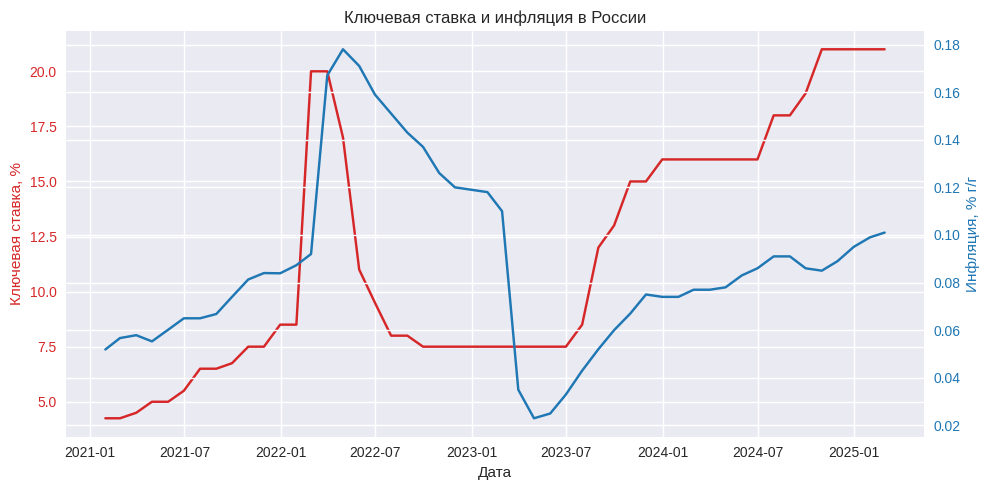

In [ ]:
# Совместная визуализация ключевой ставки и инфляции
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = "tab:red"
ax1.set_xlabel("Дата")
ax1.set_ylabel("Ключевая ставка, %", color=color1)
ax1.plot(macro["date"], macro["rate"], color=color1, label="Ключевая ставка")
ax1.tick_params(axis="y", labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.set_ylabel("Инфляция, % г/г", color=color2)
ax2.plot(macro["date"], macro["cpi_yoy"], color=color2, label="Инфляция (г/г)")
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Ключевая ставка и инфляция в России")
fig.tight_layout()
plt.show()

In [ ]:
# Простая оценка корреляции с лагом ключевой ставки
macro["key_rate_lag3"] = macro["rate"].shift(3)

corr_matrix = macro[["cpi_yoy", "key_rate_lag3"]].corr()
print("Корреляция между инфляцией и ключевой ставкой с лагом 3 месяца:")
print(corr_matrix)

Корреляция между инфляцией и ключевой ставкой с лагом 3 месяца:
                cpi_yoy  key_rate_lag3
cpi_yoy        1.000000       0.335023
key_rate_lag3  0.335023       1.000000


## 3. Учебная эконометрическая модель (синтетические данные)

В этом разделе создаём **искусственные (синтетические)** данные, чтобы продемонстрировать,
как можно оценить влияние ключевой ставки на инфляцию и рост кредитного портфеля с помощью `statsmodels`.

Эти данные не отражают реальную экономику и предназначены исключительно для демонстрации кода и методологии.

In [ ]:
# Генерация синтетических временных рядов
np.random.seed(42)

dates_syn = pd.date_range(start="2018-01-01", end="2025-12-01", freq="MS")
n = len(dates_syn)

# Синтетическая траектория ключевой ставки
key_rate_syn = (
    7 +
    1.5 * np.sin(np.linspace(0, 6, n)) +
    np.where(dates_syn >= "2024-01-01", 8, 0) +
    np.random.normal(0, 0.5, size=n)
)

# Синтетическая инфляция (обратная зависимость от ставки)
infl_syn = 10 - 0.3 * key_rate_syn + np.random.normal(0, 0.7, size=n)

# Синтетический рост кредитного портфеля
credit_growth_syn = 15 - 0.5 * key_rate_syn + np.random.normal(0, 1.0, size=n)

syn = pd.DataFrame({
    "date": dates_syn,
    "key_rate": key_rate_syn,
    "inflation": infl_syn,
    "credit_growth": credit_growth_syn
})

syn.head()

,date,key_rate,inflation,credit_growth
0,2018-01-01,7.248357,8.032777,11.589915
1,2018-02-01,7.025542,8.075076,10.241490
2,2018-03-01,7.512814,7.749735,11.416774
3,2018-04-01,8.044028,7.422581,11.363303
4,2018-05-01,7.257853,6.831885,10.487216


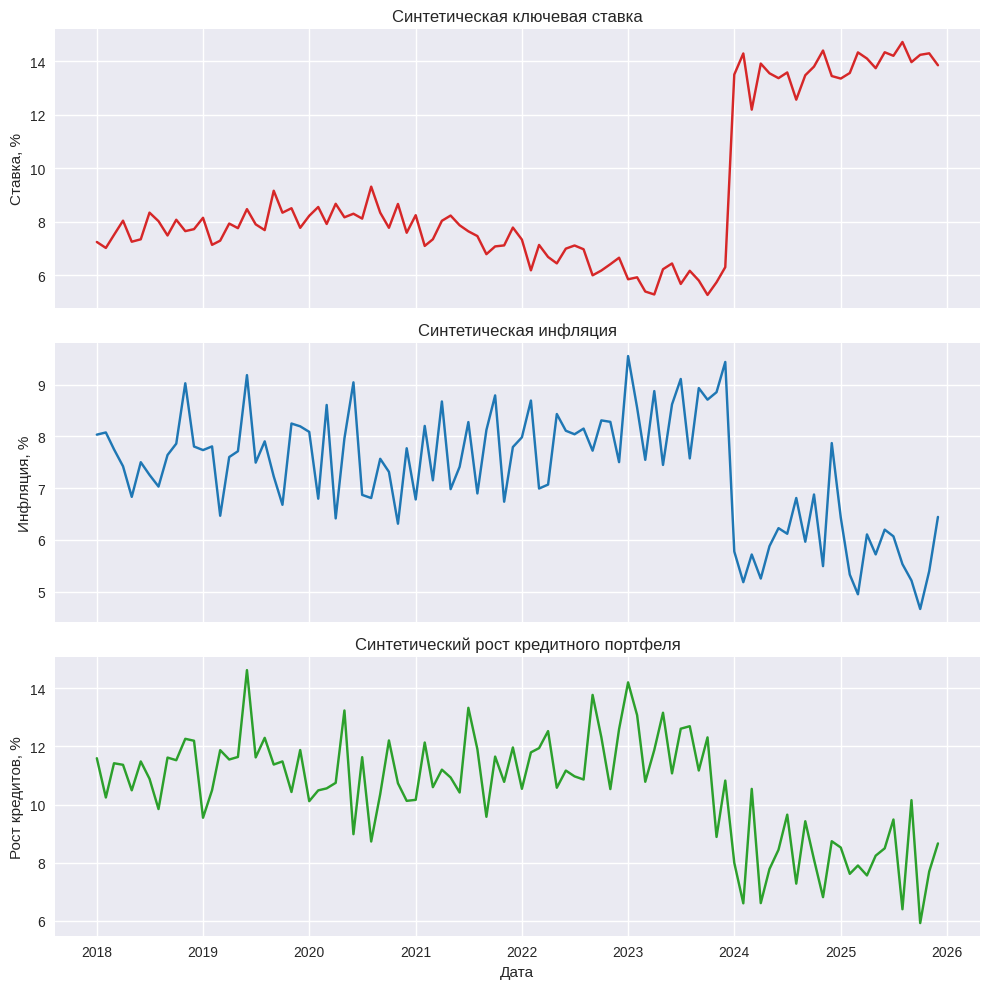

In [ ]:
# Визуализируем синтетические ряды
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axes[0].plot(syn["date"], syn["key_rate"], color="tab:red")
axes[0].set_ylabel("Ставка, %")
axes[0].set_title("Синтетическая ключевая ставка")

axes[1].plot(syn["date"], syn["inflation"], color="tab:blue")
axes[1].set_ylabel("Инфляция, %")
axes[1].set_title("Синтетическая инфляция")

axes[2].plot(syn["date"], syn["credit_growth"], color="tab:green")
axes[2].set_ylabel("Рост кредитов, %")
axes[2].set_title("Синтетический рост кредитного портфеля")
axes[2].set_xlabel("Дата")

plt.tight_layout()
plt.show()

In [ ]:
# Линейная регрессия: инфляция = a + b * ключевая_ставка
X = sm.add_constant(syn["key_rate"])
model_infl = sm.OLS(syn["inflation"], X).fit()
print(model_infl.summary())

                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     178.1
Date:                Fri, 06 Feb 2026   Prob (F-statistic):           2.05e-23
Time:                        15:44:59   Log-Likelihood:                -96.652
No. Observations:                  96   AIC:                             197.3
Df Residuals:                      94   BIC:                             202.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1438      0.220     46.057      0.0

In [ ]:
# Линейная регрессия: рост кредитов = a + b * ключевая_ставка
X2 = sm.add_constant(syn["key_rate"])
model_credit = sm.OLS(syn["credit_growth"], X2).fit()
print(model_credit.summary())

                            OLS Regression Results                            
Dep. Variable:          credit_growth   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     164.1
Date:                Fri, 06 Feb 2026   Prob (F-statistic):           2.45e-22
Time:                        15:45:03   Log-Likelihood:                -145.40
No. Observations:                  96   AIC:                             294.8
Df Residuals:                      94   BIC:                             299.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0094      0.366     41.014      0.0

## 4. Подготовка данных для современных моделей временных рядов (PatchTST и др.)

В этом разделе демонстрируется предварительная подготовка данных для дальнейшего
использования в современных моделях временных рядов (например, PatchTST на платформе Hugging Face).

Код иллюстративен и может быть адаптирован под конкретную реализацию моделей.

In [ ]:
# Подготовка данных (пример)
# Предполагаем, что DataFrame `macro` содержит месячные данные по ключевой ставке и инфляции.

macro = macro.sort_values("date").reset_index(drop=True)

features = macro[["rate"]].values
targets = macro[["cpi_yoy"]].values

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

print("Форма X_scaled:", X_scaled.shape)
print("Форма y_scaled:", y_scaled.shape)

# Далее X_scaled и y_scaled можно разбить на окна
# (context_window, forecast_horizon) и использовать
# в качестве входа для трансформеров временных рядов или других моделей.

Форма X_scaled: (50, 1)
Форма y_scaled: (50, 1)


## Выводы из анализа

На основе проделанной работы можно сделать следующие выводы:

1.  **Динамика ключевой ставки (2019–2025 гг.):**
    *   Визуализация ключевой ставки Банка России за период с 2019 по 2025 год показала значительные колебания, отражающие реакцию регулятора на экономические условия.
    *   Описательная статистика показала, что средняя ключевая ставка за этот период составила около 9.84%, с минимальным значением 4.25% и максимальным 21%.

2.  **Совместный анализ ключевой ставки и инфляции:**
    *   Визуализация показала, что ключевая ставка и годовая инфляция часто двигаются в одном направлении, однако с определенным лагом.
    *   Расчет корреляции между инфляцией и ключевой ставкой с лагом в 3 месяца показал умеренную положительную связь (корреляция ~0.335). Это может указывать на то, что изменения ключевой ставки начинают влиять на инфляцию примерно через три месяца.

3.  **Эконометрическая модель (синтетические данные):**
    *   На искусственно сгенерированных данных были построены две простые линейные регрессии для демонстрации методологии.
    *   Модель для инфляции (`inflation = a + b * key_rate`) показала отрицательную связь между ключевой ставкой и инфляцией (коэффициент около -0.312), что соответствует теоретическим ожиданиям (повышение ставки сдерживает инфляцию).
    *   Модель для роста кредитного портфеля (`credit_growth = a + b * key_rate`) также показала отрицательную связь (коэффициент около -0.498), что логично, поскольку высокая ставка делает кредиты дороже и снижает спрос на них.

4.  **Подготовка данных для современных моделей временных рядов:**
    *   Данные были успешно стандартизированы с использованием `StandardScaler`, что является необходимым шагом для большинства современных моделей машинного обучения и глубокого обучения, работающих с временными рядами.
    *   Масштабированные данные готовы для дальнейшего использования в таких моделях, как PatchTST, путем разбиения на окна для контекста и прогнозирования.